# Pre-requisites  
- download dataset.zip,  
- unzip dataset,    
- mount drive,  

In [1]:
# Package installations
from IPython.utils import io
with io.capture_output() as captured:
    !pip install gdown
    !pip3 install pillow==8.2.0
    # !pip install visdom

In [2]:
with io.capture_output() as captured:
  from google.colab import drive 
  drive.mount('/content/drive')
%cd /content/drive/MyDrive/MAI/thesis/source

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWh38w28TGrTTY1vtBu0KktUUZPmldmH4r9LpIrOxV195HdTCUWZCfg
/content/drive/MyDrive/MAI/thesis/source


In [3]:
%cd SGAN

/content/drive/MyDrive/MAI/thesis/source/SGAN


## Verify if gpu and nvidia drivers are present.

In [4]:
!nvidia-smi

Thu Sep 30 13:58:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Clone git repo

In [5]:
!git clone https://github.com/AceCoooool/DSS-pytorch.git
%cd DSS-pytorch/

fatal: destination path 'DSS-pytorch' already exists and is not an empty directory.
/content/drive/MyDrive/MAI/thesis/source/SGAN/DSS-pytorch


In [6]:
#Get pretrained VGG
!python tools/extract_vgg.py

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:06<00:00, 84.2MB/s]


In [7]:
!ls

dataset.py  LICENSE  png	  results    train_seg.txt  val_voc.txt
demo.ipynb  loss.py  __pycache__  solver.py  train_voc.txt
dssnet.py   main.py  README.md	  tools      val_seg.txt


In [8]:
f_train_seg = open("train_seg.txt", "w+")
f_val_seg = open("val_seg.txt", "w+")

In [9]:
import os
import random

ROOT_DIR = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/'

CLASSES_LIST = os.listdir(ROOT_DIR)                 # different class img in diff directories, name is class
CLASSES_LIST.sort()
ANNOT_FOLDER_NAME = "polyps/masks/"                 # only 'polyps' has seg annotations

val_list = list(range(0,len(CLASSES_LIST)))         # value list for translating Class name to number
cat_dict = dict(zip(CLASSES_LIST,val_list))         # create dictionary for translation


nline = '\n'
list_of_paths = [ROOT_DIR+i for i in CLASSES_LIST]  # calculate the different paths for each class

# Store all images and corresponding class in a list of tuples ('img_name', class_num) 
kvasir_img_list = [(f, cat_dict[p[len(ROOT_DIR):]]) for p in list_of_paths for f in os.listdir(p) if f.endswith(".jpg")]

num_images = len(kvasir_img_list)                   # find total number of img instances
random.shuffle(kvasir_img_list)                     # randomly shuffle the list

num1 = int(0.8*num_images)
num2 = num_images - num1

kvasir_train = kvasir_img_list[0:num1]
kvasir_test = kvasir_img_list[num1+1:num_images]

In [10]:
kvasir_train[0]

('4128a5ff-df5d-4b3a-9560-bd131a13526a.jpg', 0)

In [11]:
kvasir_test[0]

('5c428c14-8db1-4694-a821-61b78b338a51.jpg', 7)

In [12]:
CLASSES_LIST

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [13]:
len(kvasir_test), len(kvasir_train)

(1599, 6400)

In [14]:
cat_dict

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [15]:
for img_name, cat in kvasir_train:
    folder_name = list(cat_dict.keys())[list(cat_dict.values()).index(cat)]
    if cat is 6:
        f_train_seg.write(f'{folder_name}/{img_name}\n')

In [16]:
for img_name, cat in kvasir_test:
    folder_name = list(cat_dict.keys())[list(cat_dict.values()).index(cat)]
    if cat is 6:
        f_val_seg.write(f'{folder_name}/{img_name}\n')

f_val_seg.close()
f_train_seg.close()

## Get PASCAL VOC train and val sets

# Train the saliency model

In [18]:
!python main.py --mode='train' --train_path='/content/drive/MyDrive/MAI/thesis/source/VOCdevkit/VOC2012/JPEGImages/' --label_path='/content/drive/MyDrive/MAI/thesis/source/VOCdevkit/VOC2012/SegmentationClassAug' --batch_size=16 --visdom=False --train_file='/content/drive/MyDrive/MAI/thesis/source/SGAN/DSS-pytorch/train_voc.txt' --val_file='/content/drive/MyDrive/MAI/thesis/source/SGAN/DSS-pytorch/val_voc.txt'

Start of Solver for train...
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
epoch: [0/600], iter: [661/661], loss: [4.2062]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
epoch: [1/600], iter: [661/661], loss: [3.7923]
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
epoch: [2/600], iter: [661/661], loss: [3.4806]
[W pthreadpool-cpp.cc:90] Warning: 

# Infer saliency maps

In [ ]:
!python main.py --mode='test' --test_path='/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/' --label_path='/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/' --batch_size=8 --visdom=False --train_file='/content/drive/MyDrive/MAI/thesis/source/SGAN/DSS-pytorch/train_seg.txt' --val_file='/content/drive/MyDrive/MAI/thesis/source/SGAN/DSS-pytorch/train_seg.txt'

Start of Solver for test ...
./results
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[0] mae: 0.2874
[1] mae: 0.3588
[2] mae: 0.2128
[3] mae: 0.3103
[4] mae: 0.4235
[5] mae: 0.2930
[6] mae: 0.2273
[7] mae: 0.2352
[8] mae: 0.3176
[9] mae: 0.3179
[10] mae: 0.3329
[11] mae: 0.5071
[12] mae: 0.4185
[13] mae: 0.2431
[14] mae: 0.4753
[15] mae: 0.4674
[16] mae: 0.4192
[17] mae: 0.2511
[18] mae: 0.2967
[19] mae: 0.1581
[20] mae: 0.3719
[21] mae: 0.2601
[22] mae: 0.2804
[23] mae: 0.1800
[24] mae: 0.3983
[25] mae: 0.3201
[26] mae: 0.4395
[27] mae: 0.3517
[28] mae: 0.1885
[29] mae: 0.4260
[30] mae: 0.3165
[31] mae: 0.2194
[32] mae: 0.1726
[33] m

# Demo

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-kwx09wh9
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-kwx09wh9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import torch
from PIL import Image
from torchvision import transforms, utils
from torch.nn import functional as F
from dssnet import build_model
from tools.visual import plot_image, make_simple_grid
from tools.crf_process import crf
%matplotlib inline

In [ ]:
select = [1, 2, 3, 6] # inference: choose the side map (see paper)
use_cuda = True
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

In [ ]:
import PIL.Image
PIL.Image.__version__

'8.2.0'

In [ ]:
img_path = './png/demo_img.jpg'
def save_imgs()
img = PIL.Image.open(img_path)

img_shape = (img.size[1], img.size[0])
print('image size (HxW): ', img_shape)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(img).unsqueeze(0).to(device)

image size (HxW):  (400, 300)


In [ ]:
def load_ckp(net, checkpoint_fpath):
        checkpoint = torch.load(checkpoint_fpath)
        net.load_state_dict(checkpoint['state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer'])
        return net

In [ ]:
from dssnet import build_model, weights_init

In [ ]:
net = build_model().to(device)
vgg_path = '/content/drive/MyDrive/MAI/thesis/source/SGAN/weights/vgg16_feat.pth'
net.apply(weights_init)
net.base.load_state_dict(torch.load(vgg_path))

<All keys matched successfully>

In [ ]:
fname = '/content/drive/MyDrive/MAI/thesis/source/SGAN/DSS-pytorch/results/run-4/models/epoch_500.pth' 
model = load_ckp(net, fname)

In [ ]:
with torch.no_grad():
    prob_pred = model(image)
    prob_final = torch.mean(torch.cat([prob_pred[i] for i in select], dim=1), dim=1, keepdim=True)

# upsampling to original size
prob_pred = [F.interpolate(prob, img_shape, mode='bilinear', align_corners=True).cpu().data.squeeze(0) for prob in prob_pred]
prob_final = F.interpolate(prob_final, img_shape, mode='bilinear', align_corners=True).cpu().data.squeeze(0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


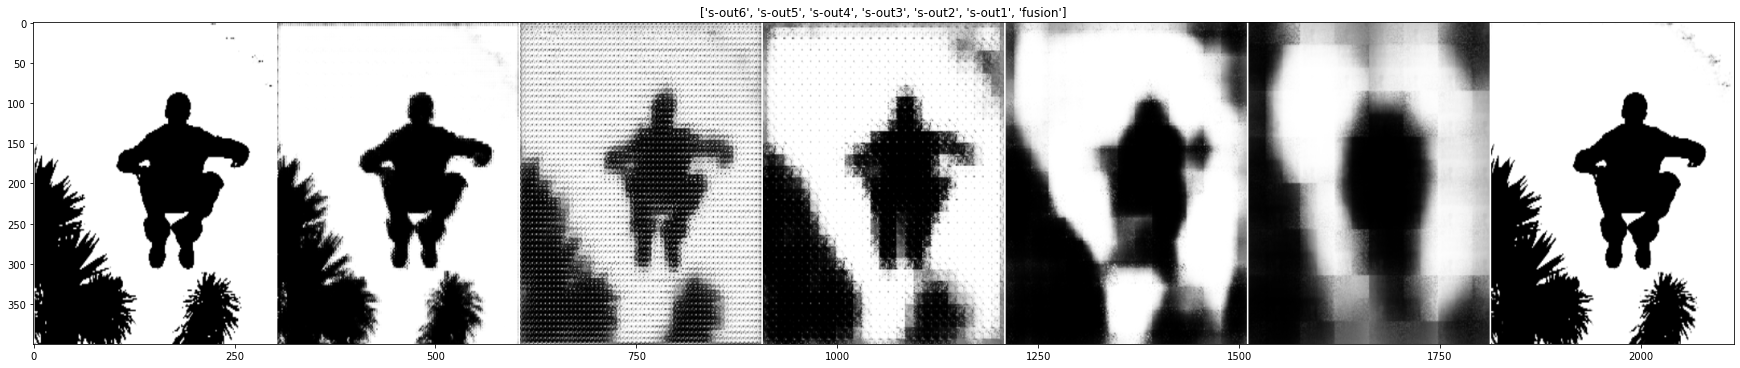

In [ ]:
# output of sides and fusion
ratio = 160/(img_shape[1]*7)
title = ['s-out6', 's-out5', 's-out4', 's-out3', 's-out2', 's-out1', 'fusion']
plot_image(make_simple_grid(prob_pred), (img_shape[0]*ratio, 160), title=title)



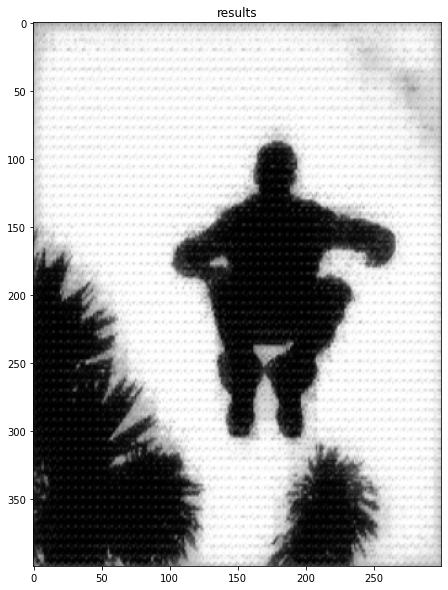

In [ ]:
plot_image(prob_final, (img_shape[0]/30, img_shape[1]/30), 'results')

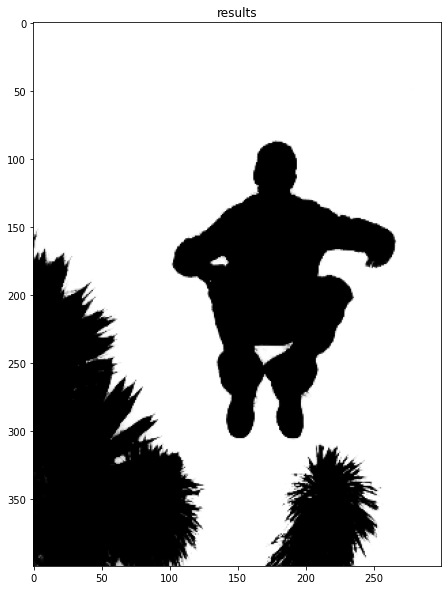

In [ ]:
# crf process
prob_final = crf(img, prob_final)
plot_image(prob_final, (img_shape[0]/30, img_shape[1]/30), 'results')